<a href="https://colab.research.google.com/github/jakinng/A-PINN/blob/main/adv_diff1d_spr2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Define FNO model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.io import loadmat

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

class SpectralConv1d(nn.Module):
    """
    Spectral Convolutional 1D Layer.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.

    Attributes:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        modes1 (int): Number of Fourier modes to multiply, at most floor(N/2) + 1.
        scale (float): Scaling factor for the weights.
        weights1 (nn.Parameter): Learnable weights for the convolution.

    Methods:
        compl_mul1d(input, weights): Performs complex multiplication between input and weights.
        forward(x): Forward pass of the SpectralConv1d layer.
    """

    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes are kept, at most floor(N/2) + 1

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        """
        Performs complex multiplication between input and weights.

        Args:
            input (torch.Tensor): Input tensor of shape (batch, in_channel, x).
            weights (torch.Tensor): Weights tensor of shape (in_channel, out_channel, x).

        Returns:
            torch.Tensor: Result of complex multiplication of input and weights, of shape (batch, out_channel, x).
        """
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        # in_channel is the common dimension along which the operation is performed.
        # It suggests that every channel (or feature) of the input is being transformed into a new set of channels (or features) in the output.
        # The operation iterates over each batch and each position x, multiplying the input channels
        # by the corresponding weights and summing the results to produce the output channels.

        # For a given position i in the x dimension and a given batch element:
        # Take all values in A at this position and batch (A[batch, :, i]) – a slice of shape (in_channel).
        # Take all corresponding values in B at this position (B[:, :, i]) – a matrix of shape (in_channel, out_channel).
        # Multiply these values element-wise and sum over the in_channel dimension.
        # This produces a vector of shape (out_channel), representing the transformed features at position i for this batch element.
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # Compute Fourier coeffcients
        x_ft = torch.fft.rfft(x)  # [Batch, C_in, Nx] -> [Batch, C_in, Nx//2 + 1], eg. [20, 64, 128] -> [20, 64, 65]

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(x.shape[0], self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat) # [Batch, Nc, Nx//2 + 1], eg. [20, 64, 65]
        # [Batch, C_in, self.modes1] * [C_in, C_out, self.modes1] -> [Batch, C_out, self.modes1]
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))  # [Batch, C_out, self.modes1] -> [Batch, C_out, Nx], eg. [20, 64, 65] -> [20, 64, 128]
        return x


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        """
        1D Fourier Neural Operator model.

        Args:
            modes (int): Number of spectral modes.
            width (int): Number of hidden channel.
        """
        super(FNO1d, self).__init__()
        self.modes1 = modes
        self.width = width
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x) MeshgridTensor + initial condition

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # stage 1: lift the channel from 2 to self.width = 64
        x = self.fc0(x)         # [Batch, Nx, C] -> [Batch, Nx, Width], eg. [20, 128, 2] -> [20, 128, 64]
        x = x.permute(0, 2, 1)  # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 2: integral operators u' = (W + K)(u).
        # W is the linear transformation; K is the spectral convolution kernel.
        x1 = self.conv0(x)      # [Batch, C, Nx], eg. [20, 64, 128]
        x2 = self.w0(x)         # [Batch, C, Nx], eg. [20, 64, 128]
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.relu(x)           # [Batch, C, Nx], eg. [20, 64, 128]

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2             # [Batch, C, Nx], eg. [20, 64, 128]

        # stage 3: put the channel back to 1
        x = x.permute(0, 2, 1)  # [Batch, Nx, C], eg. [20, 128, 64]
        x = self.fc1(x)         # [Batch, Nx, C] -> [Batch, Nx, 128], eg. [20, 128, 64] -> [20, 128, 128]
        x = F.relu(x)
        x = self.fc2(x)         # [Batch, Nx, C] -> [Batch, Nx, 1], eg. [20, 128, 128] -> [20, 128, 1]

        return x

### Newton's Method

In [84]:
# Adapted from https://jax.quantecon.org/newtons_method.html
# https://wiki.math.ntnu.no/_media/tma4125/2017v/newton.pdf

# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import jax
from jax import numpy as jnp
from jax import jit
from IPython.display import HTML # display videos

"""
Computes a root of f using Newton's method, with initial guess x_0
Uses jax control flow (jax.lax.while_loop) so that the function can be vectorized (for parareal)
Does not work for functions with 1D inputs and outputs

Parameters:
* f : the function to find a root of
* x_0 : the initial guess for a root
* tol : newton's method converges if the error is below the tolerance
* max_iter : the maximum number of iterations
"""

def newton_parareal(f, x_0, tol = 1e-6, max_iter = 3):
    df = jax.jacfwd(f) # Jacobian of f
    error = jnp.inf
    N = x_0.shape[0]
    e_all = jnp.zeros(shape = (max_iter + 1, 1))
    x_all = jnp.zeros(shape = (max_iter + 1, N))
    e_all = e_all.at[0].set(error)
    x_all = x_all.at[0].set(x_0)
    n_iter = 0

    init_val = (x_all, n_iter, e_all, tol, max_iter)
    def cond_fun(val):
        x_all, n_iter, e_all, tol, max_iter = val
        error = e_all[n_iter]
        return jnp.all(jnp.logical_and(n_iter < max_iter, error > tol))

    def body_fun(val):
        x_all, n_iter, e_all, tol, max_iter = val
        n_iter += 1
        x = x_all[n_iter - 1]
        dfx = df(x)
        x_n = x - jnp.linalg.lstsq(dfx, f(x))[0] # x_n = x - JF(x)^{-1}f(x)
        x_all = x_all.at[n_iter].set(x_n)
        error = jnp.linalg.norm(x_all[n_iter] - x_all[n_iter - 1]) / jnp.linalg.norm(x_all[n_iter - 1])
        e_all = e_all.at[n_iter].set(error)
        return x_all, n_iter, e_all, tol, max_iter
    val = init_val
    x_all, n_iter, e_all, tol, max_iter = jax.lax.while_loop(cond_fun, body_fun, init_val)

    return x_all, n_iter, e_all

def plot_function_1d(f, range, label = '$f(x)$', x_label = '$x$', y_label = '$f(x)$', show = True):
    n = 100
    fontsize = 12
    x = jnp.linspace(range[0], range[1], n)
    fig, ax = plt.subplots()
    ax.plot(x, f(x), label = label)
    ax.set_xlabel(x_label, fontsize = fontsize)
    ax.set_ylabel(y_label, fontsize = fontsize)
    ax.axhline(color = 'black', linestyle = '--', linewidth = 1)
    ax.legend(fontsize = fontsize)
    if show:
        plt.show()
    return fig, ax

def plot_data(data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False, xlabel = "x", ylabel = "y"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlabel != "t":
        ax.set_aspect('equal')
    vmin = jnp.min(data) if vmin is None else vmin
    vmax = jnp.max(data) if vmax is None else vmax
    if X is None or Y is None:
        p = ax.pcolormesh(data, vmin = vmin, vmax = vmax)
    else:
        # p = ax.pcolormesh(data)
        # print(f"{data.shape=}, {X.shape=}, {Y=}")

        p = ax.pcolormesh(X, Y, data, vmin = vmin, vmax = vmax)

        # p = ax.pcolormesh(X)#, vmin = vmin, vmax = vmax)

    cbar = plt.colorbar(p, ax = ax)
    if show:
        plt.show()
    return fig, plt, p

class Solver():
    def __init__(self, N, N_t, dt, bounds, seed, ic, bc, dim = 2, folder = "/content/drive/MyDrive/superUROP", equation = "adv-diff", initializer = None, parareal_iters = 1):
        self.N = N
        self.N_t = N_t
        self.dt = dt
        self.bounds = bounds
        self.dim = dim
        if dim == 2:
            self.L, self.dx, self.x, self.y, self.X, self.Y = self.domain(N, bounds)
        if dim == 1:
            self.L, self.dx, self.x, self.t, self.X, self.T = self.domain(N, bounds)
        self.seed = seed
        self.key = jax.random.PRNGKey(seed)
        self.u = self.initial_condition(ic, bc)
        self.ic = ic
        self.bc = bc
        self.folder = folder
        self.equation = equation
        self.test_name = self.test_name(equation)
        self.initializer = lambda x: x.flatten() if initializer is None else initializer
        self.parareal_iters = parareal_iters

    """
    Helper function returning a plot of the data
    """
    def plot_data(self, data, title = "", X = None, Y = None, vmin = None, vmax = None, show = False):
        if dim == 2:
            return plot_data(data, title = title, X = self.X, Y = self.Y, show = show)
        if dim == 1:
            return plot_data(data, title = title, X = self.T, Y = self.X, xlabel = "t", ylabel = "x", show = show)

    """
    Helper function returning u with the boundaries set to 0
    """
    def dirichlet(self, u):
        if self.dim == 2:
            u_top = 0.0
            u_left = 0.0
            u_bottom = 0.0
            u_right = 0.0
            u = u.at[-1, :].set(u_top)
            u = u.at[0, :].set(u_bottom)
            u = u.at[:, 0].set(u_left)
            u = u.at[:, -1].set(u_right)
            return u
        if self.dim == 1:
            u = u.at[-1].set(0.0)
            u = u.at[0].set(0.0)

    def diffusion_coefficient(self, u):
        if self.dim == 2:
            # x_reshape = x.reshape(self.N, self.N)
            grad_y, grad_x = jnp.gradient(u)
            grad_norm2 = jnp.linalg.norm(jnp.array([grad_x, grad_y]), axis = 0) ** 2 # Norm-squared of the gradient of solution
            d = jnp.exp(-1 * grad_norm2) # Diffusion coefficient
            # min = jnp.min(d)
            # max = jnp.max(d)
            # return 0
            return d # / 30
        if self.dim == 1:
            grad_x = jnp.gradient(u)
            grad_norm2 = jnp.linalg.norm(jnp.array([grad_x]), axis = 0) ** 2 # Norm-squared of the gradient of solution
            d = jnp.exp(-1 * grad_norm2) # Diffusion coefficient
            return d / 3

    def advection_velocity(self):
        if self.dim == 2:
            v_x = 5
            v_y = 20
            v_x = 0
            v_y = 0
            return v_x, v_y
        if self.dim == 1:
            v_x = 3.0
            return v_x

    def test_name(self, equation):
        return f"{equation}_{self.ic}_{self.bc}_{self.N}x{self.N}_{self.seed}_dt{self.dt}"

    def domain(self, N, bounds):
        L = bounds[1] - bounds[0]
        x = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
        dx = L / N
        if self.dim == 2:
            y = jnp.linspace(bounds[0], bounds[1], N, endpoint = False)
            X, Y = jnp.meshgrid(x, y)
            return L, dx, x, y, X, Y
        if self.dim == 1:
            t = jnp.arange(0, self.dt * self.N_t, self.dt)
            X, T = jnp.meshgrid(x, t)
            return L, dx, x, t, X, T

    def initial_condition(self, ic, bc):
        # Initialize the solution grid of u(k, i, j)
        if dim == 2:
            u = jnp.zeros((self.N_t, self.N, self.N))
        if dim == 1:
            u = jnp.zeros((self.N_t, self.N))
        noise = jax.random.normal(key = self.key, shape = u[0].shape) # Gaussian noise
        # Set the initial condition
        if ic == 1:
            u = u.at[0, self.N // 4 : 3 * self.N // 4, self.N // 4 : 3 * self.N // 4].set(1)
            noise_level = 0.1

        elif ic == 2:
            # coeffs = jax.random.normal(key = self.key, shape = (5, 3))
            coeffs = jax.random.normal(key = self.key, shape = (10, 3))
            if self.dim == 2:
                def poly(x, y):
                    omegas = jnp.geomspace(0.5, 2, coeffs.shape[0])
                    return jnp.sum(coeffs[:, 0] * jnp.cos(x * omegas + coeffs[:, 1]) * jnp.cos(y * omegas + coeffs[:, 2]))
                v = jax.vmap(jax.vmap(poly))(self.X, self.Y)
                scale = 2
                v = scale * (2 * v - jnp.min(v) - jnp.max(v)) / (jnp.max(v) - jnp.min(v)) # rescale to range -10 to 10
                threshold = 20
                v = jnp.clip(threshold * v, -scale, scale)
            if self.dim == 1:
                def poly(x):
                    omegas = jnp.rint(jnp.geomspace(1, 10, coeffs.shape[0]))
                    print(f"{omegas=}")
                    # omegas = jnp.linspace(0, 4, coeffs.shape[0])
                    return jnp.sum(coeffs[:, 0] * jnp.cos(x * omegas + coeffs[:, 1]))

                v = jax.vmap(poly)(self.x)
                scale = 2
                v = scale * (2 * v - jnp.min(v) - jnp.max(v)) / (jnp.max(v) - jnp.min(v)) # rescale to range -10 to 10
                # threshold = 20
                # v = jnp.clip(threshold * v, -scale, scale)
                # v = jnp.sin(v)

            # clip at threshold and rescale to (-1, 1)
            u = u.at[0].set(v)

            # add noise so DF is not NAN
            noise_level = 0.00
        elif ic == 3:
            u = u.at[0, :, :].set(100 * (1 - ((self.X - jnp.pi) / jnp.pi) ** 2) * (1 - ((self.Y - jnp.pi) / jnp.pi) ** 2))
            noise_level = 10

        elif ic == 4:
            u = u.at[0].set(jnp.exp(- ((self.X - (self.bounds[1] - self.bounds[0]) / 2) ** 2 + (self.Y - (self.bounds[1] - self.bounds[0]) / 2) ** 2)))
            noise_level = 0.1

        # Set the boundary conditions
        u = u.at[0].set(u[0] + noise_level * noise)
        match bc:
            case "dirichlet":
                u = u.at[0].set(self.dirichlet(u[0]))
            case "neumann":
                u = u.at[0, (self.N - 1):, :].set(u[0, self.N - 2 : self.N - 1, :])
                u = u.at[0, :, :1].set(u[0, :, 1:2])
                u = u.at[0, :1, :].set(u[0, 1:2, :])
                u = u.at[0, :, (self.N - 1):].set(u[0, :, self.N - 2:self.N - 1])
            case "periodic":
                pass
        return u

    def F(self, u):
        if self.dim == 2:
            u = u.reshape(self.N, self.N)
            v_x, v_y = self.advection_velocity()
            if self.bc == "dirichlet":
                if v_x > 0:
                    # Dirichlet boundary conditions
                    # Multiply by velocity (https://iopscience.iop.org/article/10.1088/1742-6596/1180/1/012009/pdf)
                    pad_x = jnp.pad(u * v_x, pad_width = ((0, 0), (1, 0)))
                elif v_x <= 0:
                    pad_x = jnp.pad(u * v_x, pad_width = ((0, 0), (0, 1))) # Dirichlet boundary conditions
                if v_y > 0:
                    pad_y = jnp.pad(u * v_y, pad_width = ((1, 0), (0, 0)))
                elif v_y <= 0:
                    pad_y = jnp.pad(u * v_y, pad_width = ((0, 1), (0, 0)))

                grad_vx = (pad_x[:, 1:] - pad_x[:, :-1]) / self.dx
                grad_vy = (pad_y[1:, :] - pad_y[:-1, :]) / self.dx
                op = -1 * (grad_vx + grad_vy)
            if self.bc == "periodic":
                if v_x > 0:
                    pad_x = jnp.roll(u * v_x, shift = 1, axis = 1)
                    grad_vx = (pad_x - u * v_x) / self.dx
                elif v_x <= 0:
                    pad_x = jnp.roll(u * v_x, shift = -1, axis = 1)
                    grad_vx = (pad_x - u * v_x) / self.dx
                if v_y > 0:
                    pad_y = jnp.roll(u * v_y, shift = 1, axis = 0)
                    grad_vy = (pad_y - u * v_y) / self.dx
                elif v_y <= 0:
                    pad_y = jnp.roll(u * v_y, shift = -1, axis = 0)
                    grad_vy = (pad_y - u * v_y) / self.dx
                op = -1 * (grad_vx + grad_vy)

            d = self.diffusion_coefficient(u)
            lap_kernel = 1 / (self.dx ** 2) * jnp.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
            if self.bc == "periodic":
                op += d * 1 * jax.scipy.signal.convolve2d(jnp.pad(u, 1, mode = "wrap"), lap_kernel, mode = "valid", boundary = "fill", fillvalue = 0) # pad outside
                plt.pcolormesh(op)
                plt.show()
            if self.bc == "dirichlet":
                # Set boundaries to zero
                op += d * 1 * jax.scipy.signal.convolve2d(u, lap_kernel, mode = "same", boundary = "fill", fillvalue = 0)
                op = self.dirichlet(op)
            return op.flatten()
        if self.dim == 1:
            v_x = self.advection_velocity()
            if self.equation == "advection":
                if self.bc == "periodic":
                    if v_x > 0:
                        pad_x = jnp.roll(u * v_x, shift = 1, axis = 0)
                        grad_vx = (pad_x - u * v_x) / self.dx
                    elif v_x <= 0:
                        pad_x = jnp.roll(u * v_x, shift = -1, axis = 0)
                        grad_vx = (pad_x - u * v_x) / self.dx
                    op = -1 * grad_vx
                    d = self.diffusion_coefficient(u)
                    lap_kernel = 1 / (self.dx ** 2) * jnp.array([1, -2, 1])
                    op += d * 1 * jax.scipy.signal.convolve(jnp.pad(u, 1, mode = "wrap"), lap_kernel, mode = "valid")#, boundary = "fill", fillvalue = 0) # pad outside

                return op

    def finite_difference(self, diffusion_coefficient = None):
        if dim == 2:
            v_x, v_y = self.advection_velocity()
            C = jnp.abs(v_x * self.dt / self.dx) + jnp.abs(v_y * self.dt / self.dx)
            print(f"The Courant number at x = 0, y = 0 is {C}. Stable if C <= 1.")
            for k in range(self.N_t - 1):
                op = self.F(self.u[k]).reshape(self.N, self.N)
                self.u = self.u.at[k + 1].set(self.u[k] + dt * op) # Add delta u term
                self.u = self.u.at[k + 1].set(self.dirichlet(self.u[k + 1]))
            filename = f"{self.folder}/{self.test_name}"
            jnp.save(filename, self.u)
        if dim == 1:
            v_x = self.advection_velocity()
            C = jnp.abs(v_x * self.dt / self.dx)
            print(f"The Courant number at x = 0, y = 0 is {C}. Stable if C <= 1.")
            for k in range(self.N_t - 1):
                op = self.F(self.u[k])
                self.u = self.u.at[k + 1].set(self.u[k] + dt * op) # Add delta u term
                if self.bc == "periodic":
                    pass
                if self.bc == "dirichlet":
                    self.u = self.u.at[k + 1].set(self.dirichlet(self.u[k + 1]))
            filename = f"{self.folder}/{self.test_name}"
            jnp.save(filename, self.u)
        # self.test_name += "finite_diff"

    def backward_euler(self, max_newton_iter = 10):
        if self.dim == 2:
            print(f"{max_newton_iter=}")
            for k in range(self.N_t - 1):
                x_0 = initializer(self.u[k])
                # Find root x satisfying x - u[k] = dt * (op(x)) and set it to be u[k + 1]
                x_all, n_iter, e_all = newton_parareal(f = lambda x: x - self.u[k].flatten() - self.dt * self.F(x), x_0 = x_0, max_iter = max_newton_iter)
                print(f"{e_all=}")
                self.u = self.u.at[k + 1].set(x_all[n_iter].reshape(self.N, self.N))
        if self.dim == 1:
            print(f"{max_newton_iter=}")
            for k in range(self.N_t - 1):
                x_0 = initializer(self.u[k])
                # Find root x satisfying x - u[k] = dt * (op(x)) and set it to be u[k + 1]
                x_all, n_iter, e_all = newton_parareal(f = lambda x: x - self.u[k] - self.dt * self.F(x), x_0 = x_0, max_iter = max_newton_iter)
                # print(f"{e_all=}")
                # plt.plot(x_all[n_iter])
                # plt.show()
                # print(f"{k=}")
                self.u = self.u.at[k + 1].set(x_all[n_iter])
        jnp.save(f"{self.folder}/{self.test_name}_newton", self.u)
        # self.test_name += "newton"

    def animate_solution(self, u, description = "", folder = None, test_name = None):
        folder = self.folder if folder is None else folder
        test_name = self.test_name if test_name is None else test_name
        fig, plt, p = self.plot_data(u[0], title = f"Solution at t = {0 * self.dt:.3f}", vmin = jnp.min(u), vmax = jnp.max(u))

        def animate(k):
            p.set_array(u[k])
            p.set_clim(jnp.min(u), jnp.max(u))
            plt.title(f"Solution at t = {k * self.dt:.3f}")

        anim = animation.FuncAnimation(fig, animate, frames = self.N_t, repeat=False)
        FFwriter = animation.FFMpegWriter(fps = 20)
        anim.save(f"{folder}/{test_name}.mp4", writer = FFwriter, dpi = 300)
        return anim

    def parareal(self, predict, true_solution = np.array([0]), max_newton_iter = 10, NG = 5):
        def predict(x):
            # Find root x satisfying x - u[k] = dt * (op(x)) and set it to be u[k + 1]
            x_all, n_iter, e_all = newton_parareal(f = lambda x_next: x_next - x - self.dt * NG * self.F(x_next), x_0 = x, max_iter = max_newton_iter)
            return x_all[n_iter]

        previous_G = true_solution #jnp.zeros(shape = self.u.shape)
        previous_G = previous_G.at[0].set(self.u[0]) # Set the initial condition

        # Coarse integrator
        for k in range(0, self.N_t - NG, NG):
            unroll = previous_G[k]
            # for i in range(NG):
            unroll = predict(unroll)
            # self.u = self.u.at[k + NG].set(unroll)
            previous_G = previous_G.at[k + NG].set(unroll)

        self.plot_data(previous_G, show = True, title = "Coarse prediction")
        self.plot_data(previous_G - true_solution, show = True, title = "Coarse prediction diff")

        @jit
        def fine_solver(x_0):
            # stop_index = start_index + NG - 1 # start_index = 0, stop_index = 4
            fine_u = jnp.zeros(shape = (NG + 1, self.N))
            fine_u = fine_u.at[0].set(x_0)
            for j in range(NG): #start_index, stop_index, 1): # j = 0, 1, 2, 3, 3
                # x_0 = self.u[j].flatten()
                x_all, n_iter, e_all = newton_parareal(f = lambda x: x - x_0 - self.dt * self.F(x), x_0 = x_0, max_iter = max_newton_iter)
                x_0 = x_all[n_iter]
                fine_u = fine_u.at[j + 1].set(x_0)
            return fine_u

        iter = 0
        parareal_errs_array = []
        errs_array = []

        previous_F = true_solution

        fine_solver_parallel = jax.vmap(fine_solver)
        while iter < self.parareal_iters:
            start_idxs = jnp.arange(0, self.N_t, NG)
            print(f"{start_idxs=}, {iter=}")
            start_x0s = []
            for i in start_idxs:
                start_x0s.append(previous_G[i])
            fine_us = fine_solver_parallel(jnp.array(start_x0s))

            print(f"{fine_us.shape=}")

            for i in range(self.N_t // NG):
                for j in range(1, NG + 1):
                    if i + j < self.N_t:
                        previous_F = previous_F.at[i * NG + j].set(fine_us[i][j])
                        # self.plot_data(self.u[i * NG + j], title = f"at idx {i * NG + j}", show = True)
                        # plt.close()

            self.plot_data(previous_F, show = True, title = f"Fine solver after {iter} parareal iterations")
            self.plot_data(previous_F - true_solution, show = True, title = f"Fine solver diff after {iter} parareal iterations")

            # for k in range(0, self.N_t - NG, NG):
            #     unroll = self.u[k]
            #     # for i in range(NG):
            #     unroll = predict(unroll)
            #     new_G = new_G.at[k + NG].set(unroll)

            # self.plot_data(new_G, show = True, title = f"coarse predictions {iter}")
            # self.plot_data(new_G - true_solution, show = True, title = f"diff coarse predictions {iter}")
            # self.plot_data(new_G - previous_G, show = True, title = f"coarse predictions vs initial predictions {iter}")
            # self.plot_data(self.u - true_solution + (new_G - previous_G), show = True, title = f"compare error with delta that we make {iter}")


            parareal_errs = []
            errs = []
            # new_u = jnp.zeros(shape = self.u.shape)
            # new_u = new_u.at[0].set(self.u[0])
            new_u = jnp.copy(self.u)
            # new_G = jnp.zeros(shape = self.u.shape)
            # new_G = new_G.at[0].set(self.u[0])
            new_G = jnp.copy(self.u)
            for k in range(0, self.N_t - NG, NG):
                # parareal_errs.append(jnp.max(new_G[k + NG] - previous_G[k + NG]))
                # self.u = self.u.at[k + NG].add(predict(self.u[k]) - previous_G[k + NG]) #self.u.at[k + NG] +
                # print(f"{new_u[k]=}")
                # print(f"{predict(new_u[k])}")
                # print(f"{predict(new_u[k]).shape=}")
                # plt.plot(self.u[k + NG], label = "current value")
                # plt.plot(previous_G[k + NG], label = "previous prediction")
                # plt.legend()
                # plt.show()
                new_G = new_G.at[k + NG].set(predict(new_u[k]))
                new_u = new_u.at[k + NG].set(self.u[k + NG] + new_G[k + NG] - previous_G[k + NG])
                parareal_errs.append(jnp.max(new_G[k + NG] - previous_G[k + NG]))

            self.plot_data(previous_G - true_solution, show = True, title = f"previous G diff {iter}")
            self.plot_data(new_G - true_solution, show = True, title = f"new G diff {iter}")
            self.plot_data(new_G - previous_G, show = True, title = f"adjustment {iter}")

            self.plot_data(self.u, show = True, title = f"before parareal correction {iter}")
            self.plot_data(new_u, show = True, title = f"after parareal correction {iter}")
            self.plot_data(new_u - true_solution, show = True, title = f"diff after parareal correction {iter}")
            self.plot_data(self.u - true_solution, show = True, title = f"diff before parareal correction {iter}")
            # After updating, evaluate the PDE residual at each point
            # for k in range(1, self.N_t):
            #     f = lambda k: self.u[k] - self.u[k - 1] - self.dt * self.F(self.u[k])
            #     errs.append(jnp.mean(f(k)))
            #     plt.plot(f(k))
            #     plt.show()

            self.u = new_u
            previous_G = jnp.copy(new_G)

            # previous_G = jnp.copy(new_G)
            parareal_errs_array.append(parareal_errs)
            plt.figure()
            for i, parareal_errs in enumerate(parareal_errs_array):
                plt.plot(jnp.arange(0, self.N_t - NG, NG), parareal_errs, label = i)
            # plt.plot(jnp.arange(1, self.N_t), errs, label = i)
            plt.title("Error at each time, for each parareal iteration")
            plt.legend()
            plt.savefig("Parareal_errors.png")
            plt.show()

            iter += 1
            print(f"{iter=}")
            jnp.save(f"{self.folder}/{self.parareal_iters}pararealiter_{self.test_name}piter{iter}", self.u)
            self.plot_data(self.u, show = True, title = f"Parareal iteration {iter}")
N = 128
N_t = 100
bounds = jnp.array([0, 2 * jnp.pi])
cluster = False
dim = 1
ic = 2
bc = "periodic"
dt = 0.01
if cluster:
    folder = "~/superUROP/2024-04-17"
else:
    folder = "/content/drive/MyDrive/superUROP/2024-04-18"
max_newton_iter = 10

N_t = 6
true_solution = np.load(f"{folder}/50pararealiter_advection_2_periodic_128x128_0_dt0.001piter18.npy")

for seed in range(0, 0):
    initializer = lambda x: x

    solver = Solver(equation = "advection", N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer, dim = dim)
    print(f"{solver.dx}")
    solver.finite_difference() #diffusion_coefficient = lambda x: 0)
    solver.plot_data(solver.u, title = "at time 0", show = True)
    solver.backward_euler(max_newton_iter = max_newton_iter)
    print(f"Solved!")
    solver.plot_data(solver.u, title = "at time 0", show = True)

### Parareal

In [ ]:
class Config():
    #========================#
    # Training parameters
    #========================#
    num_epoch = 500                  # number of training epoch
    # num_epoch = 20
    batch_size = 20                  # batch size

    # Adam optimizer parameters
    weight_decay = 1e-4              # weight decay for Adam optimizer

    # learning rate decay parameters
    lr = 0.001                       # learning rate
    step_size = 100                  # step size for step-wise learning rate decay
    gamma = 0.5                      # the decay coefficient for step-wise learning rate decay

    modes = 16                       # number of Fourier modes to multiply, at most floor(N/2) + 1
    width = 64                       # number of hidden channel

    #========================#
    # dataset information
    #========================#
    dataset_path = 'dataset/burgers_data_R10.mat'  # use for your local computer
    sub = 8                             # downsample rate for spatial dimension
    burger_resolution_original = 2**13         # original resolution of the dataset
    advdiff_resolution_original = 2**7
    num_train = 1700                    # number of training data
    num_test = 200                      # number of test data

cfg = Config()
# cfg.dataset_path = "/content/drive/MyDrive/superUROP/2024-04-18/burgers_data_R10.mat" # update the dataset_path, this is optional

omegas=Array([ 1.,  1.,  2.,  2.,  3.,  4.,  5.,  6.,  8., 10.], dtype=float32)
max_newton_iter=10
omegas=Array([ 1.,  1.,  2.,  2.,  3.,  4.,  5.,  6.,  8., 10.], dtype=float32)
0.04908738657832146


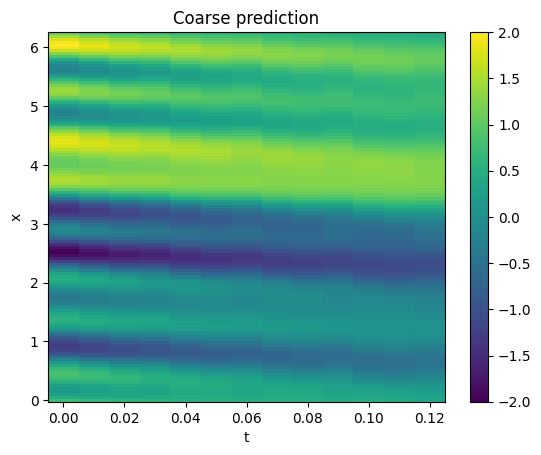

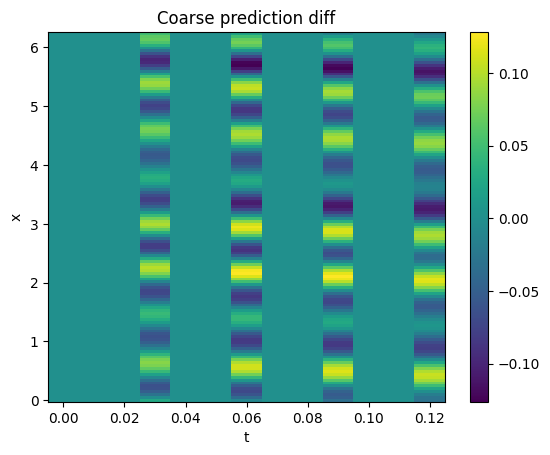

start_idxs=Array([ 0,  3,  6,  9, 12], dtype=int32), iter=0
fine_us.shape=(5, 4, 128)


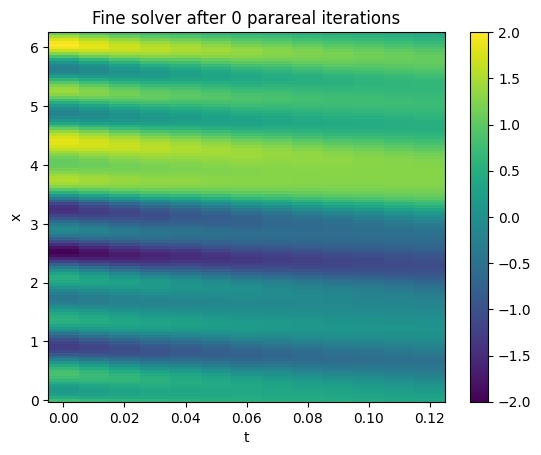

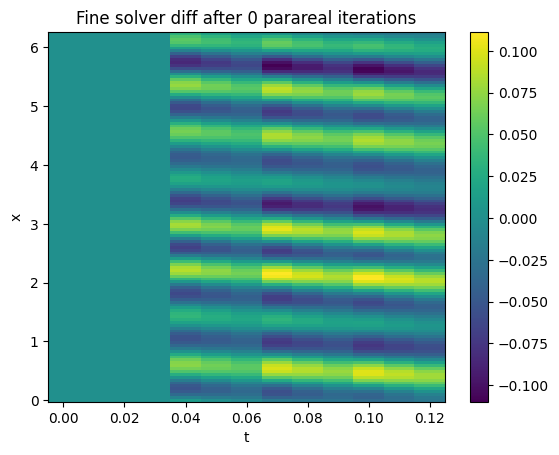

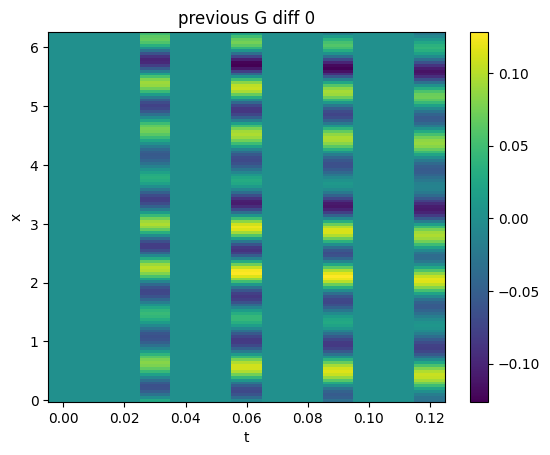

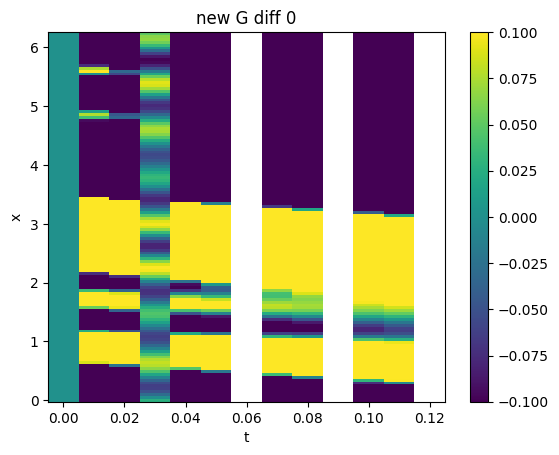

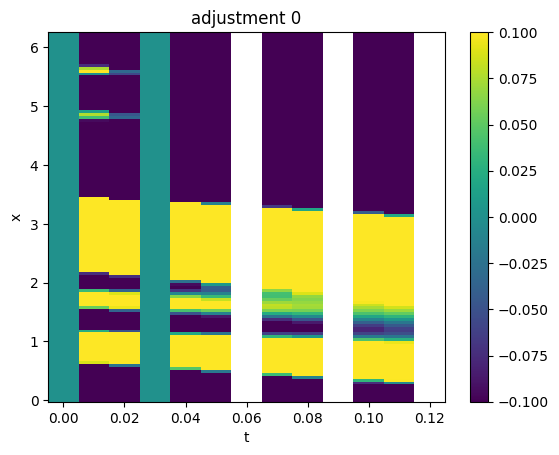

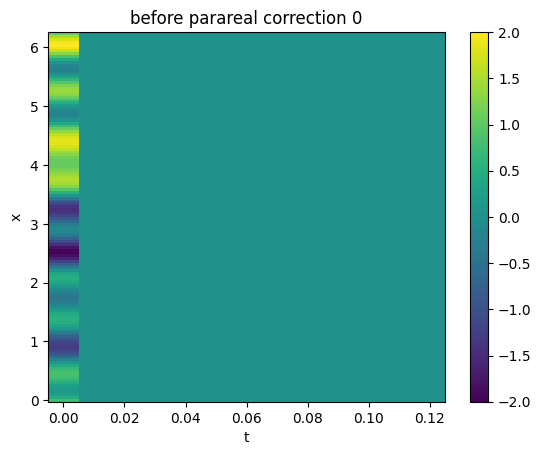

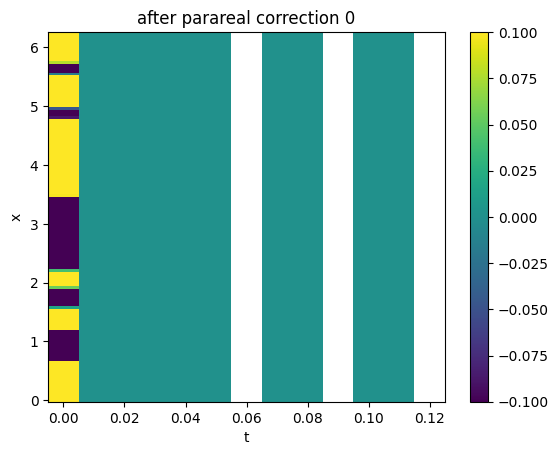

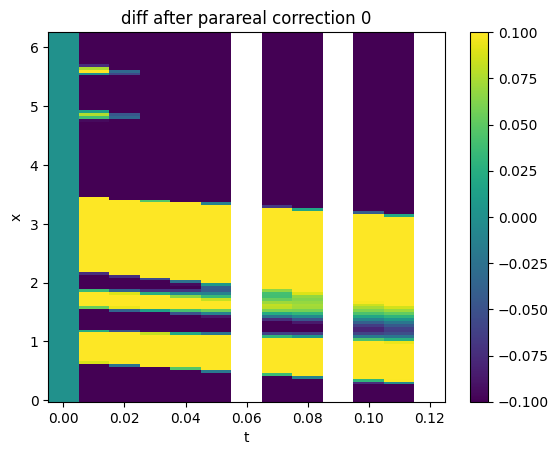

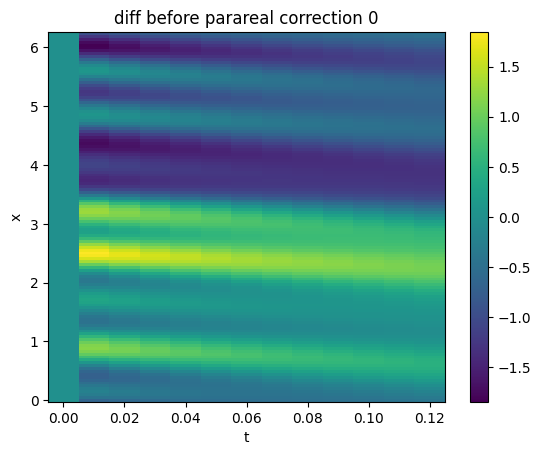

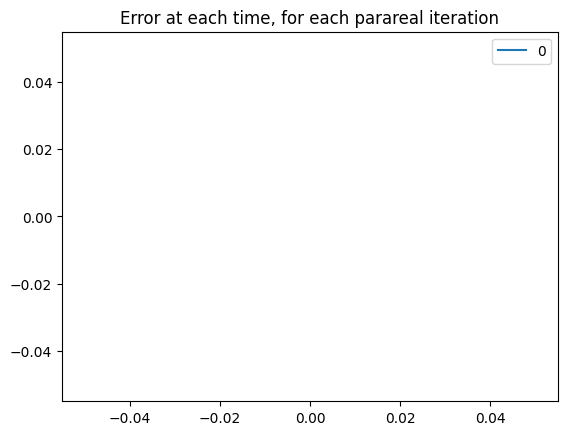

iter=1


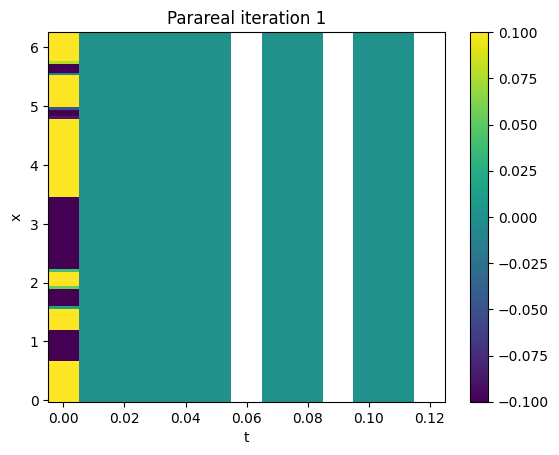

start_idxs=Array([ 0,  3,  6,  9, 12], dtype=int32), iter=1
fine_us.shape=(5, 4, 128)


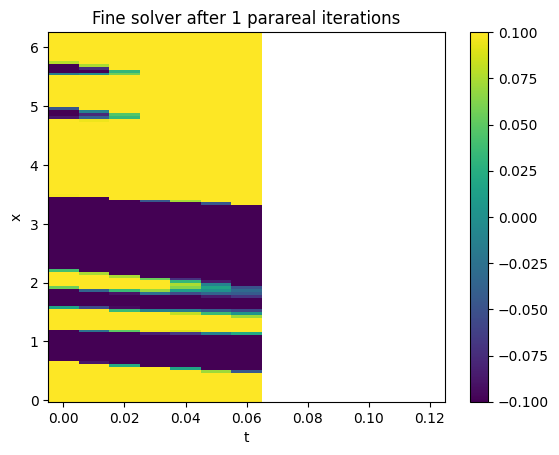

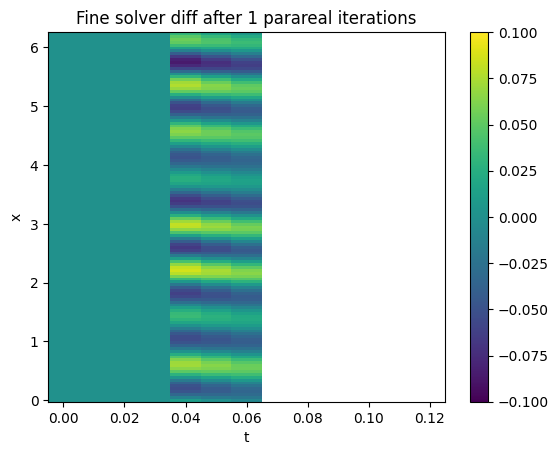

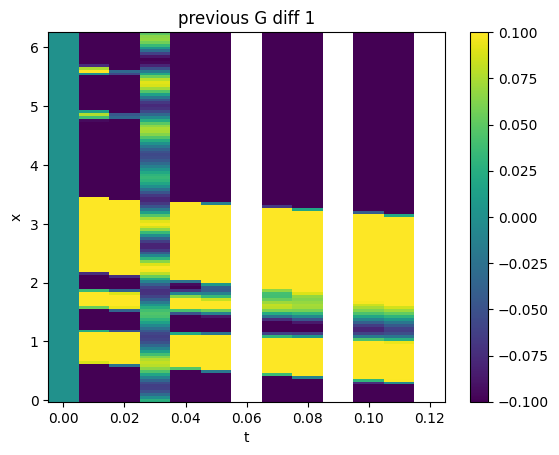

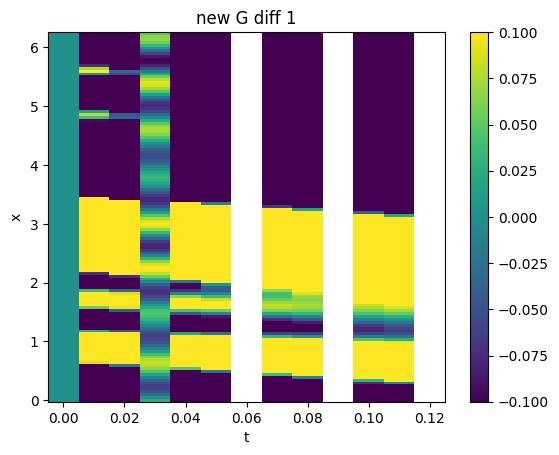

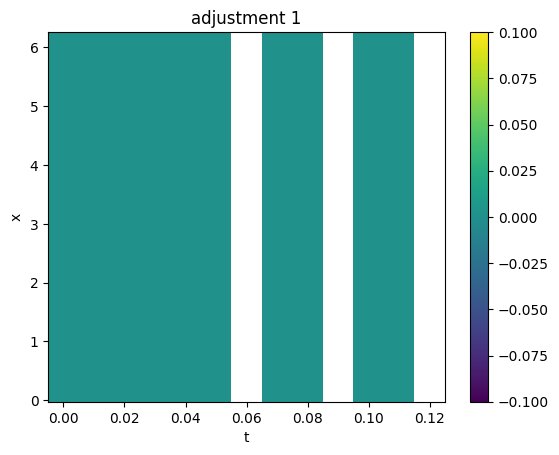

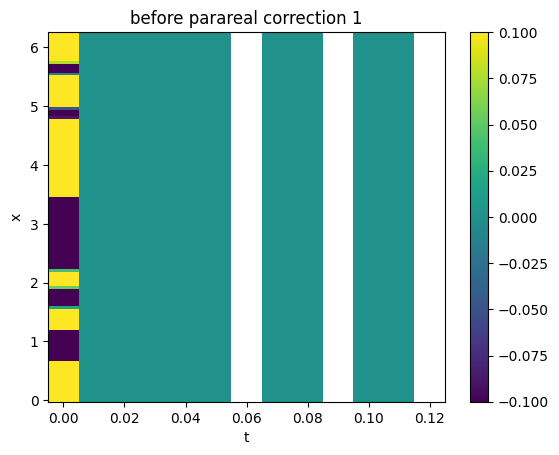

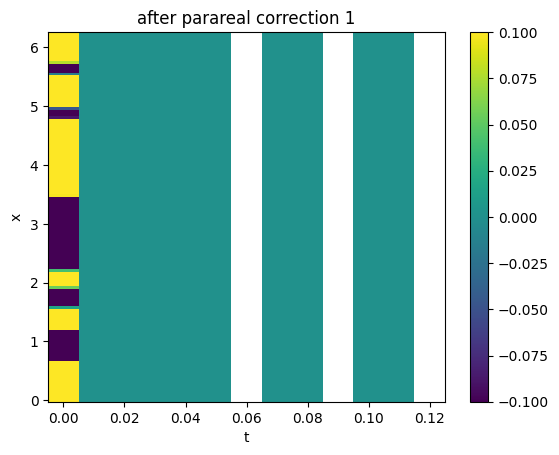

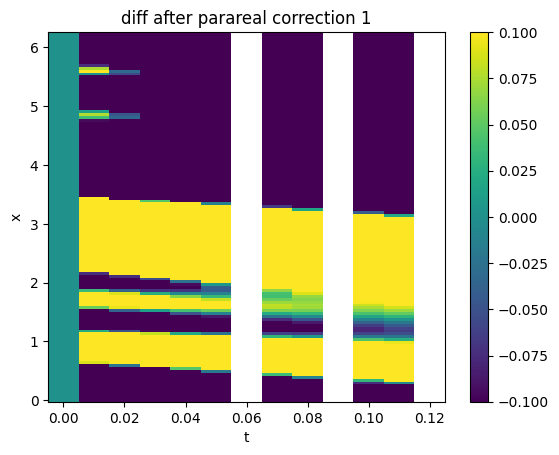

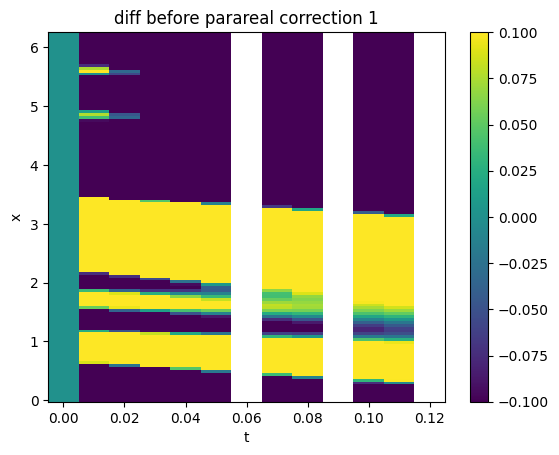

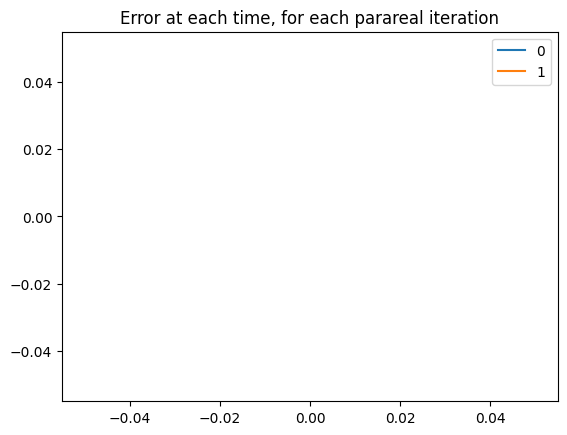

iter=2


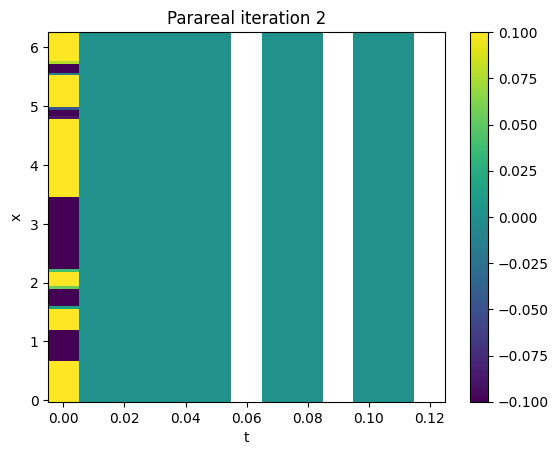

start_idxs=Array([ 0,  3,  6,  9, 12], dtype=int32), iter=2
fine_us.shape=(5, 4, 128)


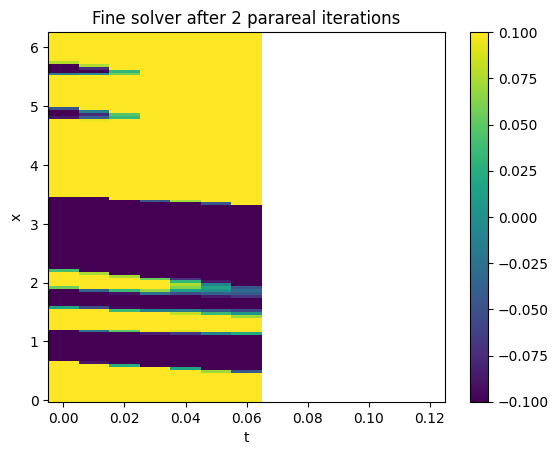

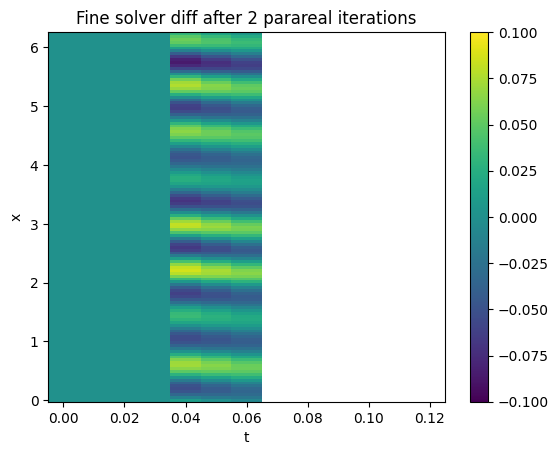

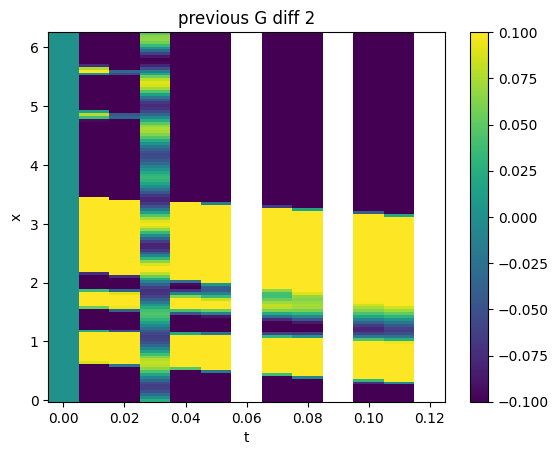

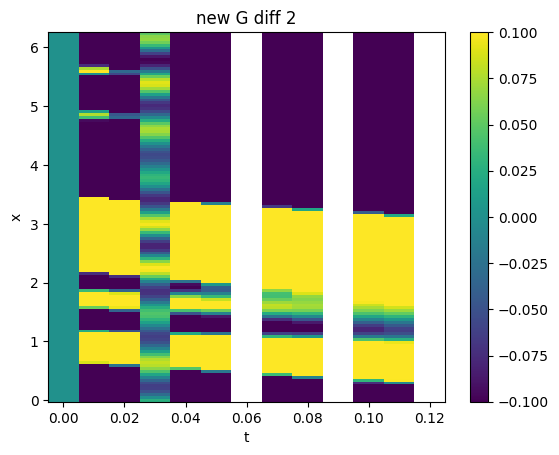

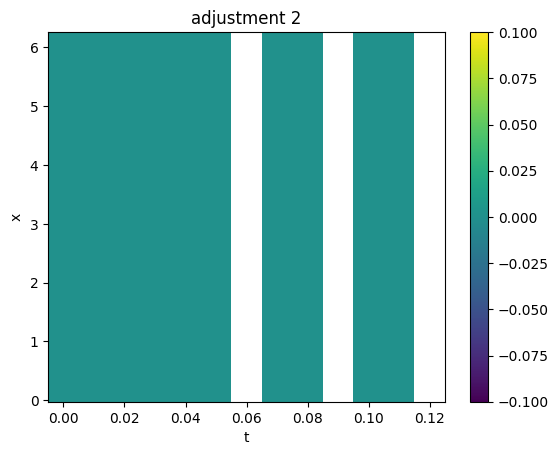

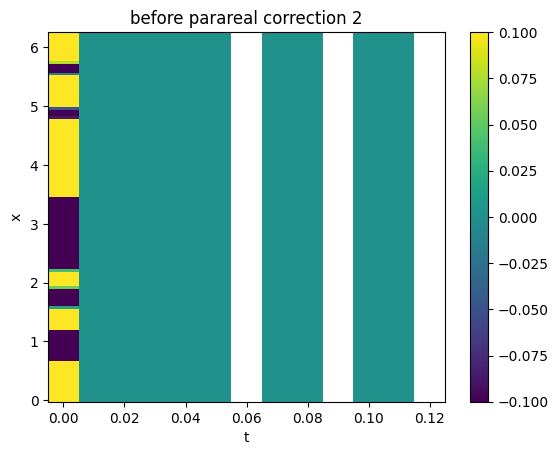

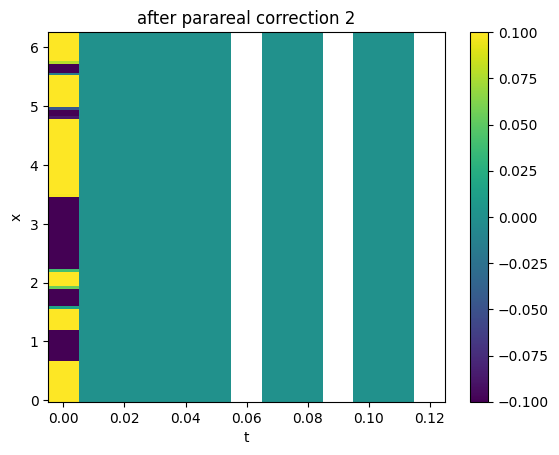

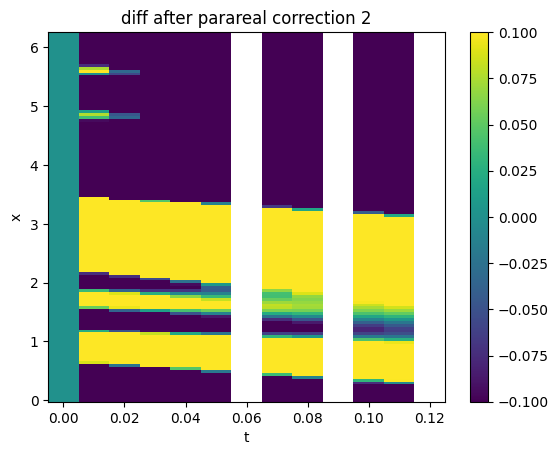

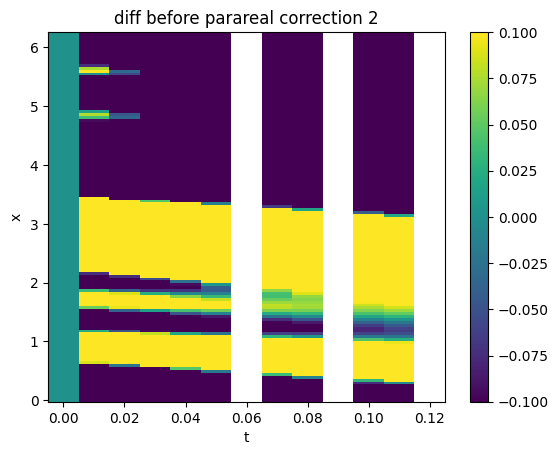

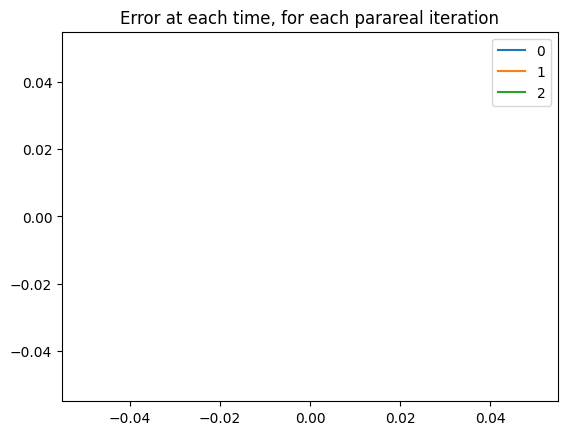

iter=3


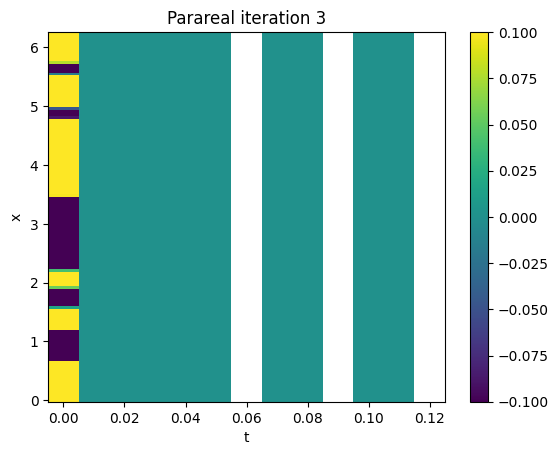

start_idxs=Array([ 0,  3,  6,  9, 12], dtype=int32), iter=3
fine_us.shape=(5, 4, 128)


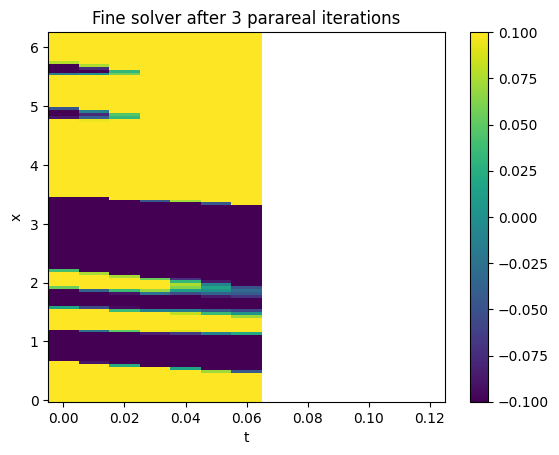

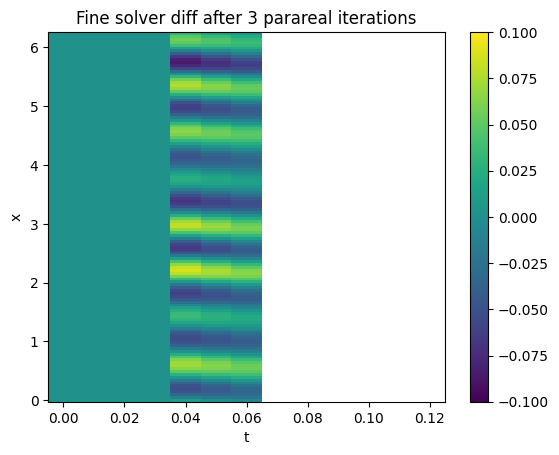

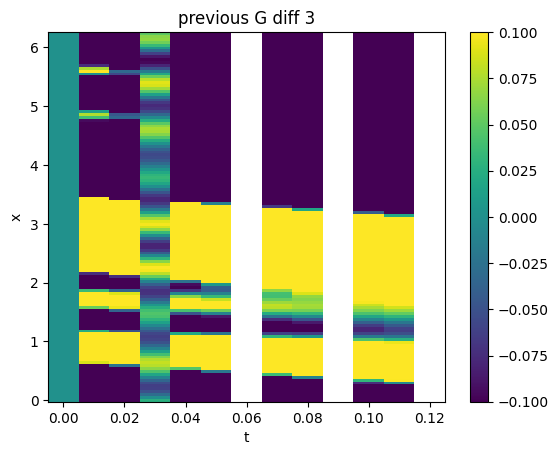

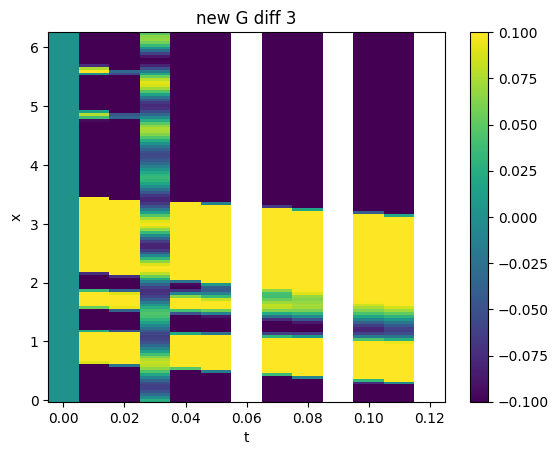

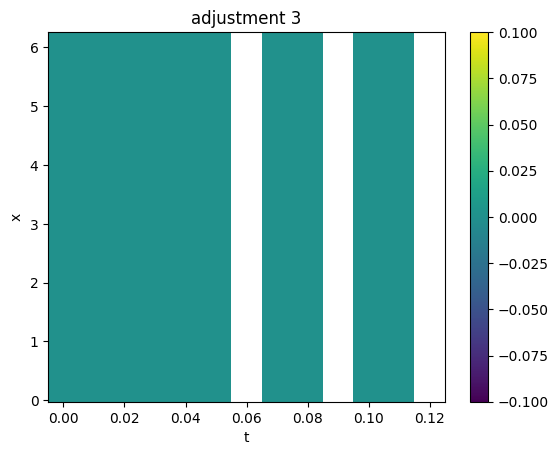

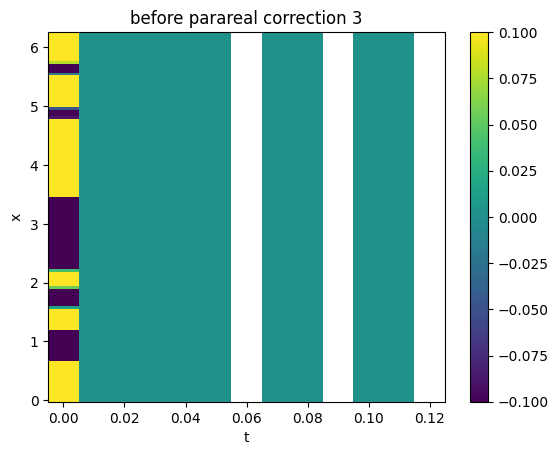

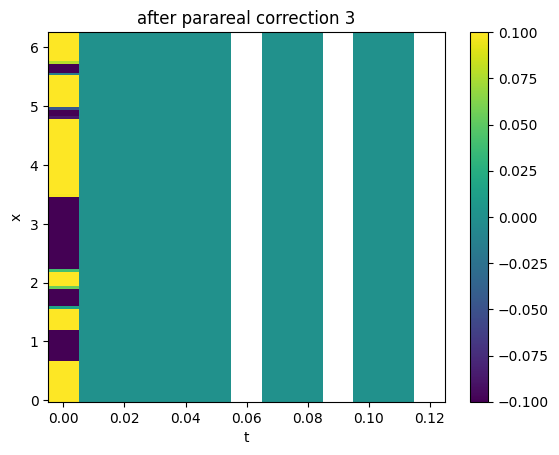

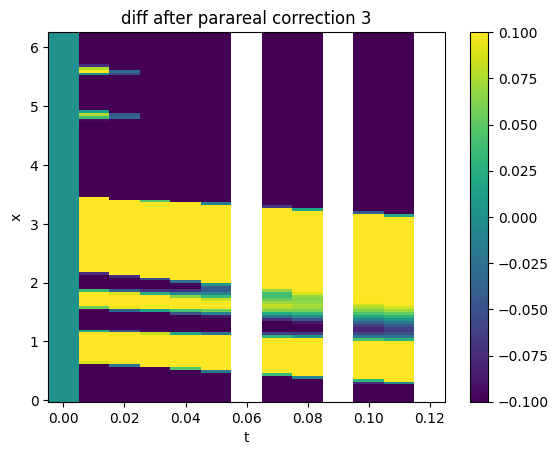

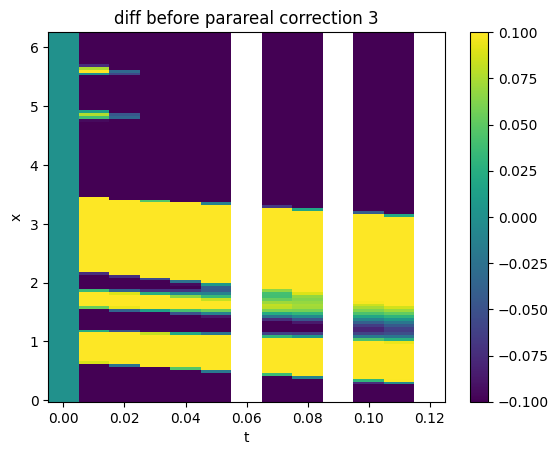

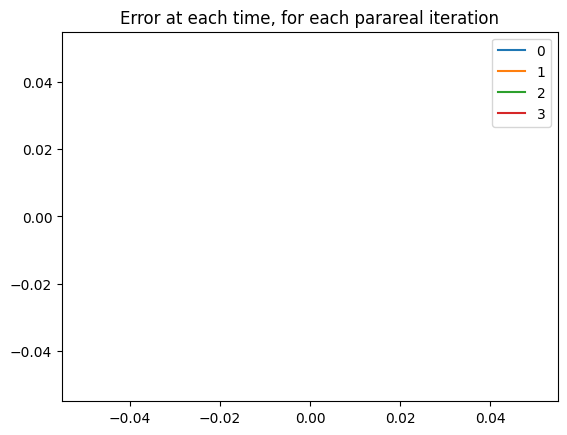

iter=4


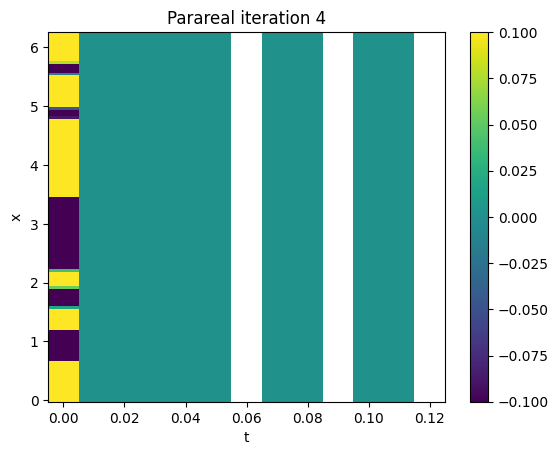

In [85]:
def predict(x, model, N, bc = "periodic", show = False):
    x = jnp.reshape(x, newshape = (1, N, 1))
    x = np.asarray(x)

    sub = cfg.advdiff_resolution_original // N
    # train_loader, test_loader = prepare_data_advdiff(sub = sub, cfg = cfg)
    grid_all = np.linspace(0, 1, cfg.advdiff_resolution_original).reshape(cfg.advdiff_resolution_original, 1).astype(np.float64)
    grid = grid_all[::sub, :]  # downsampled grid, (Nx, 1): (128, 1)
    grid = torch.tensor(grid, dtype=torch.float)

    x = torch.tensor(x, dtype=torch.float)
    # concatenate the spatial grid and the spatial solution
    x = torch.cat([x.reshape(1, -1, 1), grid.repeat(1, 1, 1)], dim=2)
    model.eval()
    with torch.no_grad():
        x = x.cuda()
        pred = model(x)

    if show:
        # plot comparison
        plt.figure()
        plt.plot(x[0].cpu().numpy(), 'b', label = "Initial condition")
        plt.plot(pred[0].cpu().numpy(), 'r', label='Prediction')
        plt.legend(loc='upper right')
        plt.title(f'resolution_test: {N}')
        plt.show()
    return pred[0, :, 0].cpu().numpy()


# model = torch.load(f"{folder}/model{description()}")
if not cluster:
    model = torch.load("/content/drive/MyDrive/superUROP/2024-04-18/modeladvection_2_periodic_128x128_dt0.005")
else:
    model = torch.load("2024-04-17/modeladv-diff_2_dirichlet_32x32_dt0.003_newton3")
# model = torch.load("/content/drive/MyDrive/superUROP/2024-03-10/modeladv-diff_2_dirichlet_32x32_dt0.003_newton")


N = 128
bounds = jnp.array([0, 2 * jnp.pi])
cluster = False
dim = 1
ic = 2
bc = "periodic"
dt = 0.01
if cluster:
    folder = "~/superUROP/2024-04-18"
else:
    folder = "/content/drive/MyDrive/superUROP/2024-04-18"
max_newton_iter = 10

N_t = 51
N_t = 13

NG = 3
parareal_iters = N_t // NG

true_solution = np.load(f"{folder}/advection_2_periodic_128x128_0_dt0.01.npy")
for seed in range(0, 1):
    initializer = lambda x: x

    solver = Solver(equation = "advection", N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer, dim = dim)
    solver.backward_euler(max_newton_iter = max_newton_iter)
    true_solution = solver.u

    initializer = lambda x: x

    solver = Solver(equation = "advection", N = N, N_t = N_t, dt = dt, bounds = bounds, seed = seed, ic = ic, bc = bc, folder = folder, initializer = initializer, dim = dim, parareal_iters = parareal_iters)
    print(f"{solver.dx}")
    # solver.finite_difference() #diffusion_coefficient = lambda x: 0)
    # solver.plot_data(solver.u, title = "at time 0", show = True)
    # solver.backward_euler(max_newton_iter = max_newton_iter)
    # print(f"Solved!")
    # solver.plot_data(solver.u, title = "at time 0", show = True)
    solver.parareal(predict = lambda x: predict(x, model, N = N), max_newton_iter = max_newton_iter, NG = NG, true_solution = true_solution)

    # true_solution = np.load(f"{folder}/50pararealiter_advection_2_periodic_128x128_0_dt0.001piter18.npy")
    # print(true_solution.shape)
    # for i in range(1, 51):
    #     # solver.plot_data(true_solution, title = "True solution", show = True)
    #     parareal_solution = np.load(f"{folder}/50pararealiter_advection_2_periodic_128x128_0_dt0.001piter{i}.npy")
    #     # solver.plot_data(parareal_solution, title = f"Parareal {i}", show = True)
    #     solver.plot_data(parareal_solution - true_solution, title = "Diff", show = True)